## Makemore 3

In [1]:
# Imports are just like before
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("names.txt", "r").read().splitlines() # Python list of strings
print(words[:8]) # show a sample of the first 8 names
print(len(words)) # this many words in total

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033


In [3]:
# Build a vocabulary of characters map them to integers
chars = sorted(list(set(''.join(words))))  # set(): Throwing out letter duplicates

stoi = {s:i+1 for i,s in enumerate(chars)} # Make tuples of type (char, counter)
stoi['.'] = 0                              # Add this special symbol's entry explicitly
itos = {i:s for s,i in stoi.items()}       # Switch order of (char, counter) to (counter, char)

vocab_size = len(itos)

# Showing the two mappings, they really just are mirrors of one another
print(itos)
print(stoi)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
27


In [4]:
# Build the dataset
block_size = 3 # Context length: How many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # Crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)

  print(X.shape, Y.shape)
  return X, Y

# Randomize the dataset (with reproducibility)
import random
random.seed(42)
random.shuffle(words)

# These are the "markers" we will use to divide the dataset
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# Dividing the dataset into train, dev and test splits
Xtr, Ytr = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
n_embd = 10    # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g  = torch.Generator().manual_seed(2147483647)                 # For reproducibility
C  = torch.randn((vocab_size, n_embd), generator=g)            # 27 letters x 10 values inp layer
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) # 10 values x 3 priors x 200 neur.
b1 = torch.randn(n_hidden, generator=g)                        # 200 biases for the 200 neurons
W2 = torch.randn((n_hidden, vocab_size), generator=g)          # 200 inputs x 27 output neurons
b2 = torch.randn(vocab_size, generator=g)                      # 27 output biases

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure
print(sum(p.nelement() for p in parameters), 'parameters') # total parameters (3481 before)

for p in parameters:
    p.requires_grad = True

11897 parameters


In [6]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y of this batch
    
    # Forward-Pass
    emb = C[Xb]                         # Embedding characters into vectors
    embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
    hpreact = embcat @ W1 + b1          # Hidden layer pre-activation
    h = torch.tanh(hpreact)             # Hidden layer
    logits = h @ W2 + b2                # Output layer
    loss = F.cross_entropy(logits, Yb)  # Loss function
    
    # Backward-Pass
    for p in parameters:
        p.grad = None # Making sure that prior iteration's gradients are gone
    loss.backward()   # This calculates the current (new) gradients
    
    # Update
    lr = 0.1 if i < (max_steps / 2) else 0.01 # Learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())

      0/ 200000: 27.8817
  10000/ 200000: 2.8938
  20000/ 200000: 2.5338
  30000/ 200000: 2.7486
  40000/ 200000: 2.0463
  50000/ 200000: 2.5262
  60000/ 200000: 2.3287
  70000/ 200000: 2.0933
  80000/ 200000: 2.2712
  90000/ 200000: 2.2558
 100000/ 200000: 2.1419
 110000/ 200000: 2.4222
 120000/ 200000: 1.8987
 130000/ 200000: 2.4745
 140000/ 200000: 2.2662
 150000/ 200000: 2.1095
 160000/ 200000: 2.2389
 170000/ 200000: 1.7758
 180000/ 200000: 2.0976
 190000/ 200000: 1.8528


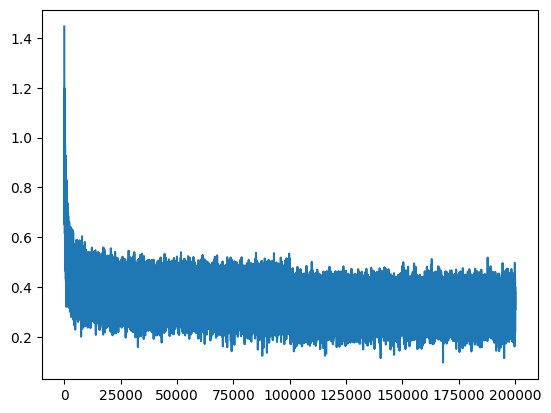

In [7]:
plt.plot(lossi);

In [8]:
# See Makemore #2. We did this before but it's refactored here for convenience:
@torch.no_grad() # Decorator, disables gradient tracking (no "book-keeping" on torch's side)
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]    # That's a switch (never seen it like this!)
    
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)
    
    h = torch.tanh(embcat @ W1 + b1)    # (N, n_hidden)
    logits = h @ W2 + b2                # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1263930797576904
val 2.169311285018921


In [9]:
# Sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # Forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      # Sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # Shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # As soon as we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # Decode and print the generated word

mora.
mayah.
seel.
nah.
yam.
remyra.
ejdrmon.
adeer.
melin.
shy.
jenleigh.
estanareelynn.
hokalin.
shubergahimies.
kendreeller.
novana.
ure.
geder.
yaruf.
ehsyn.


## Problem 1: Unrealistically High Initial Loss

In [10]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [11]:
# 4-dimensional example of this issue (instead of 27-dimensional)
logits = torch.tensor([-8.0, 5.0, 1.0, 10.0]) # "Outputs" of an MLP
probs = torch.softmax(logits, dim=0)          # Turn logits into a normalized probability distribution
loss = -probs[2].log()                        # Loss of the label for this situation is 2

probs, loss

(tensor([1.5126e-08, 6.6920e-03, 1.2257e-04, 9.9319e-01]), tensor(9.0068))

In [12]:
n_embd = 10
n_hidden = 200

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # Small, but not 0
b2 = torch.randn(vocab_size,                      generator=g) * 0 # Initialize to 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [13]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y of this batch
    
    # Forward-Pass
    emb = C[Xb]                         
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 + b1          
    h = torch.tanh(hpreact)             
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())

      0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3902
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8644
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


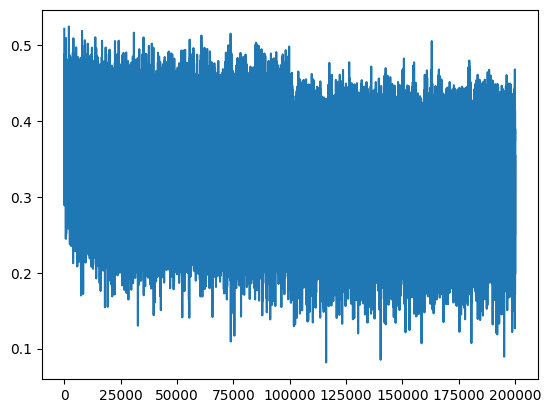

In [14]:
plt.plot(lossi);

In [15]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]                            # switch statement
    
    emb = C[x]                          # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)
    
    h = torch.tanh(embcat @ W1 + b1)    # (N, n_hidden)
    logits = h @ W2 + b2                # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.069589138031006
val 2.1310746669769287


## Problem 2: Frequent Tanh Extrema

In [16]:
print(h.shape)
print(h.view(-1).shape)

torch.Size([32, 200])
torch.Size([6400])


tensor([[ 0.7100, -0.7879, -0.7424,  ..., -1.0000,  1.0000,  1.0000],
        [-0.5616, -1.0000, -1.0000,  ..., -0.8078,  0.9971, -0.9210],
        [-1.0000,  0.9940, -1.0000,  ...,  0.3850, -0.9303,  0.3262],
        ...,
        [-0.9992, -1.0000, -0.9999,  ..., -0.4351, -0.8976, -0.3768],
        [ 0.9939,  0.8976,  1.0000,  ..., -0.9538, -1.0000,  0.9987],
        [-1.0000, -0.9995, -1.0000,  ..., -0.6407, -0.8208,  0.5101]],
       grad_fn=<TanhBackward0>) 



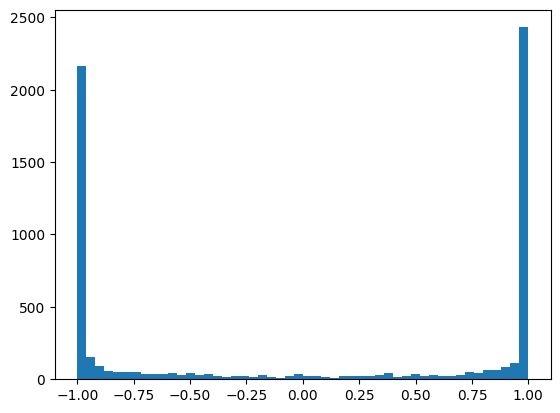

In [17]:
print(h, "\n") # hidden layer activations (32 x 200)
plt.hist(h.view(-1).tolist(), 50); # (6400 x 1), convert tensor to list, show histogram on distribution for 50 bins

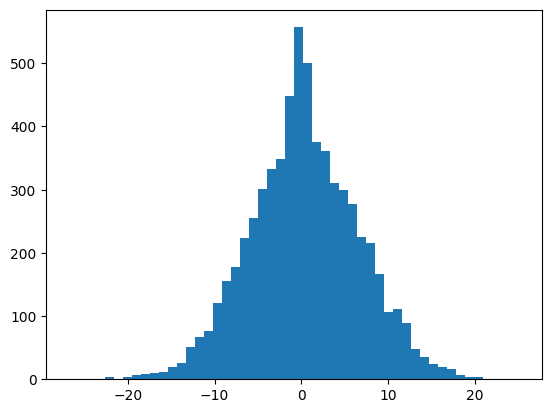

In [18]:
plt.hist(hpreact.view(-1).tolist(), 50);

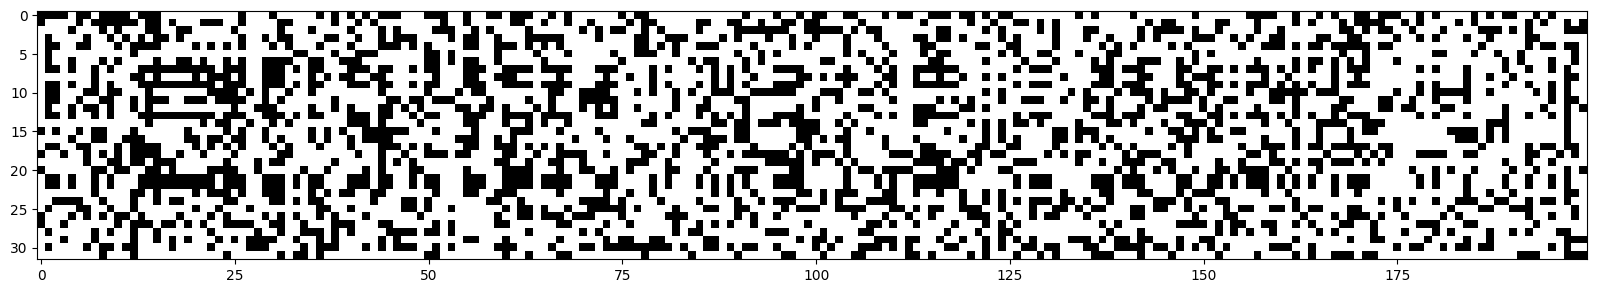

In [19]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest'); # true: white, false: black (h is 32 x 200)

In [20]:
n_embd = 10
n_hidden = 200

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2  # Small, but not 0
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 # Small, but not 0 bias
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # Small, but not 0
b2 = torch.randn(vocab_size,                      generator=g) * 0    # Biases are now all 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [21]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y of this batch
    
    # Forward-Pass
    emb = C[Xb]                         
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 + b1          
    h = torch.tanh(hpreact)             
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())
    
    break # run only the first batch

      0/ 200000: 3.3135


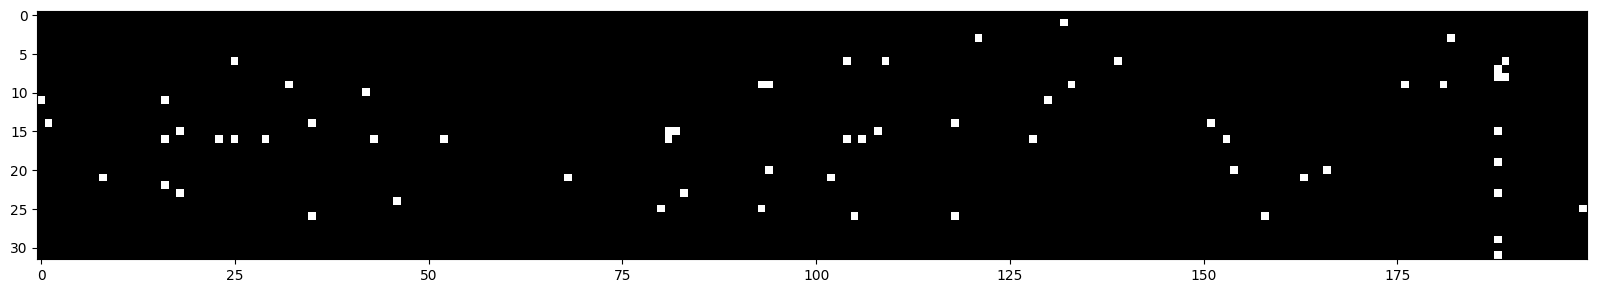

In [22]:
# We actually allow some to reach extremes, but its now rarely the case
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99 , cmap='gray', interpolation='nearest'); # true: white, false: black

tensor([[ 0.5503, -0.1064, -0.6658,  ..., -0.3477, -0.9756,  0.8880],
        [-0.9081, -0.1924, -0.1833,  ...,  0.0494,  0.4942,  0.4397],
        [ 0.8016,  0.1173,  0.8237,  ...,  0.2890,  0.6476,  0.8827],
        ...,
        [-0.9190,  0.5208, -0.0346,  ..., -0.0830,  0.8660,  0.8849],
        [-0.9362,  0.0930, -0.2810,  ..., -0.1260,  0.7874,  0.9102],
        [-0.9190,  0.5208, -0.0346,  ..., -0.0830,  0.8660,  0.8849]],
       grad_fn=<TanhBackward0>) 



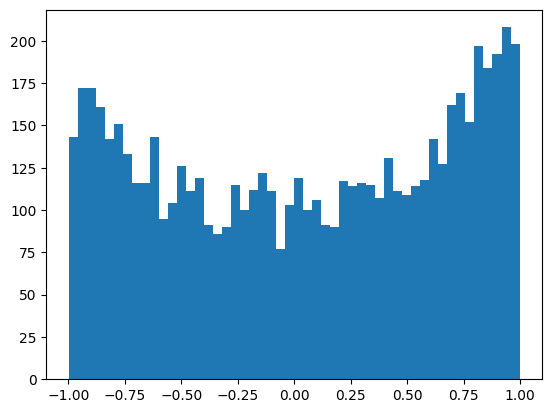

In [23]:
print(h, "\n")
plt.hist(h.view(-1).tolist(), 50);

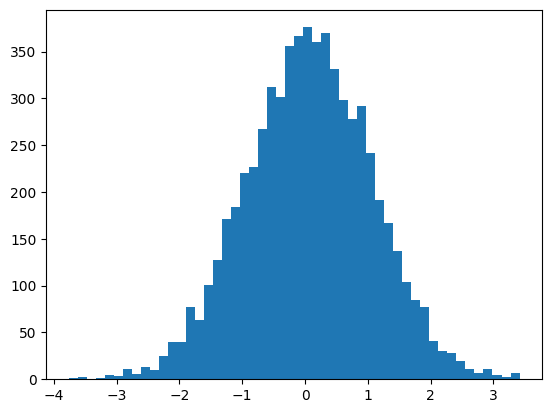

In [24]:
plt.hist(hpreact.view(-1).tolist(), 50);

In [25]:
n_embd = 10
n_hidden = 200

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # Small, but not 0
b2 = torch.randn(vocab_size,                      generator=g) * 0    # Biases are now all 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [26]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y of this batch
    
    # Forward-Pass
    emb = C[Xb]                         
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 + b1          
    h = torch.tanh(hpreact)             
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())

      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


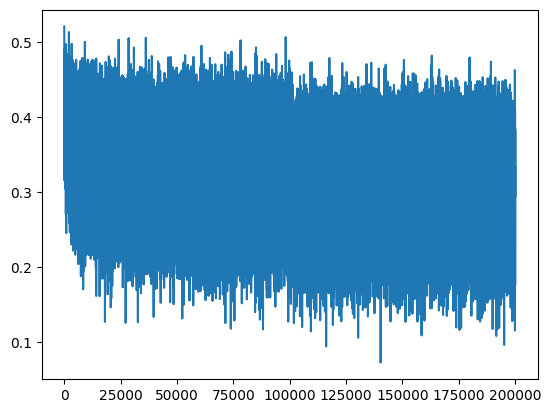

In [27]:
plt.plot(lossi);

In [28]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x]                          # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)
    
    h = torch.tanh(embcat @ W1 + b1)    # (N, n_hidden)
    logits = h @ W2 + b2                # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0355963706970215
val 2.1026782989501953


## Problem 1+2: Weight- and Bias-Scaling

X: tensor(-0.0007) tensor(0.9985)
W: tensor(-0.0090) tensor(1.0074)
Y: tensor(0.0007) tensor(3.1860)


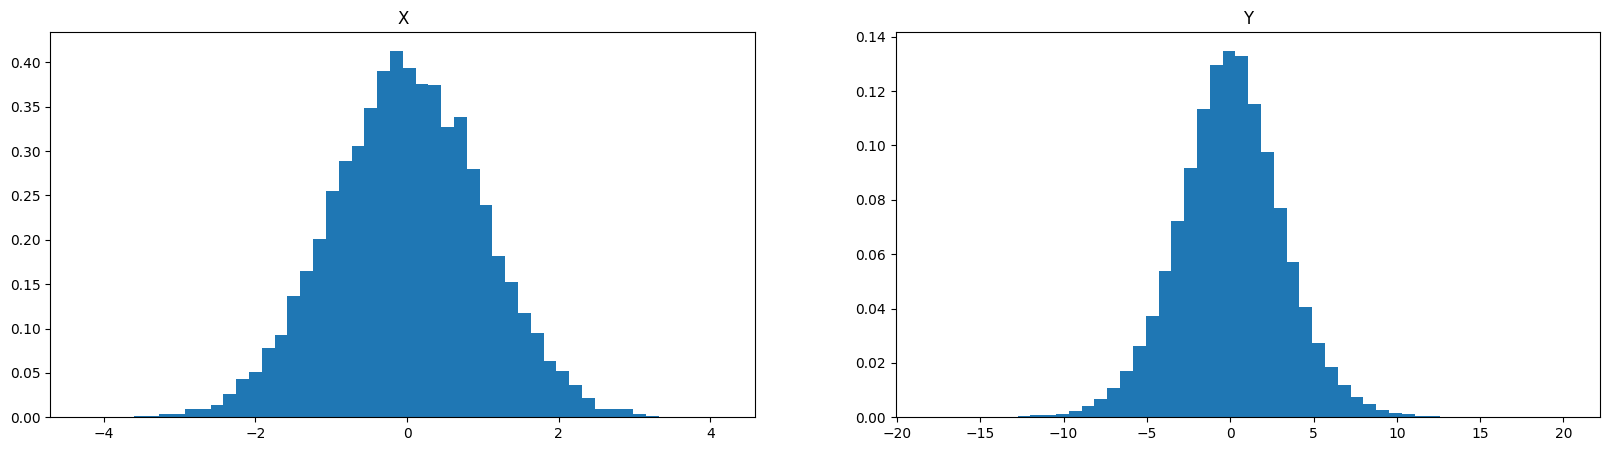

In [29]:
x = torch.randn(1000, 10) # 1000 vectors á 10 dimensions (inputs) (gaussian-distributed)
w = torch.randn(10, 200)  # 10 vectors á 200 dimensions (200 neurons, each looking at 10 inputs)

# [!] We leave out the biases b for this example

y = x @ w # Get the neurons pre-activations

print('X:', x.mean(), x.std())  # mean ~0, standard dev: ~1 (as this is Gaussian)
print('W:', w.mean(), w.std())  # mean ~0, standard dev: ~1 (also Gaussian)
print('Y:', y.mean(), y.std())  # mean ~0, standard dev: ~3 ?!

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('X')
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.title('Y')
plt.hist(y.view(-1).tolist(), 50, density=True);

X: tensor(-0.0113) tensor(0.9836)
W: tensor(-0.0022) tensor(0.3101)
Y: tensor(-0.0006) tensor(0.9642)


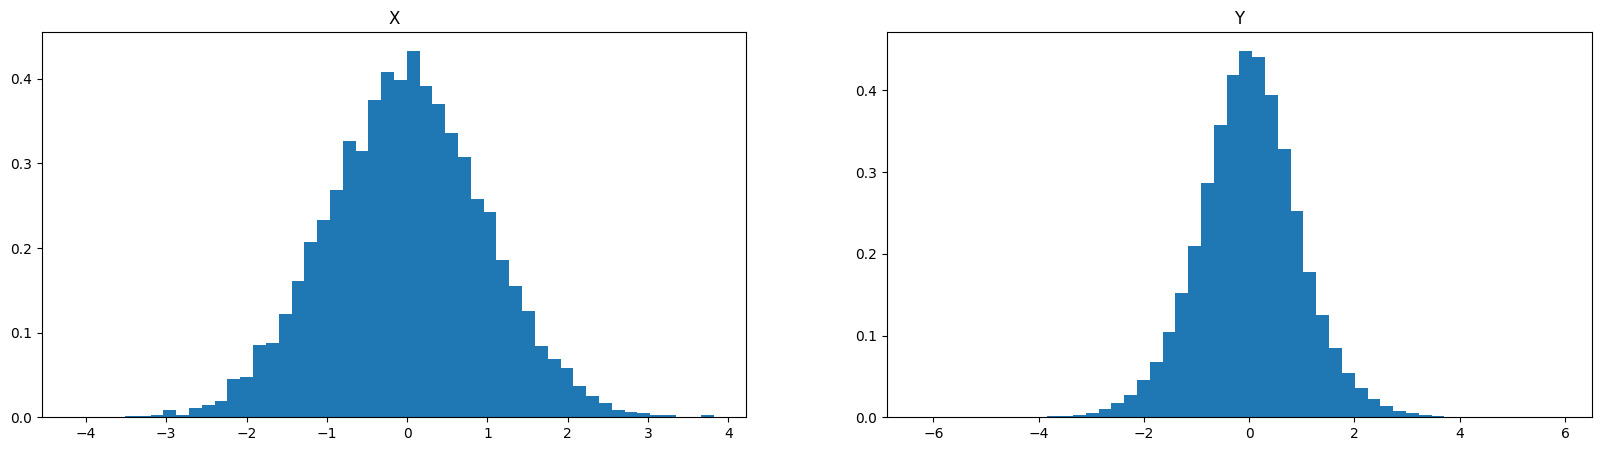

In [30]:
x = torch.randn(1000, 10) 
w = torch.randn(10, 200) * 10**-0.5 # meaning / sqrt(10) or 0.316228

y = x @ w

print('X:', x.mean(), x.std())
print('W:', w.mean(), w.std())
print('Y:', y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('X')
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.title('Y')
plt.hist(y.view(-1).tolist(), 50, density=True);

In [31]:
n_embd = 10
n_hidden = 200

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) # the factor makes the std of the output ~1
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 # Small, but not 0
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # Small, but not 0
b2 = torch.randn(vocab_size,                      generator=g) * 0    # Biases are now all 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [32]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y of this batch
    
    # Forward-Pass
    emb = C[Xb]                         
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 + b1          
    h = torch.tanh(hpreact)             
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9752
 190000/ 200000: 1.8614


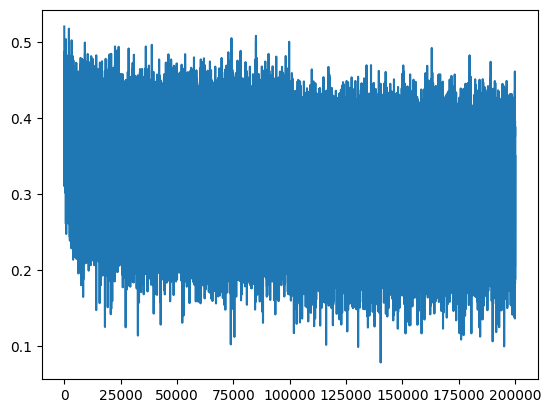

In [33]:
plt.plot(lossi);

In [34]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x]                          # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)
    
    h = torch.tanh(embcat @ W1 + b1)    # (N, n_hidden)
    logits = h @ W2 + b2                # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0376644134521484
val 2.106989622116089


## Batch Normalization

In [35]:
print('hpreact shape:', hpreact.shape) # (32, 200)

hpreact shape: torch.Size([32, 200])


In [36]:
# Step 1: Calculate the mean across 0th dimension
# The 0 indicates that we calculate the mean along the 32 inputs, so we get 200 means, one per neuron
print('mean:', hpreact.mean(0, keepdim=True).shape) # (1, 200)

mean: torch.Size([1, 200])


In [37]:
# Step 2: Calculate the standard deviation across 0th dimension
# The 0 indicates that we calculate the mean along the 32 inputs, so we get 200 standard deviations, one per neuron
print('stddev:', hpreact.std(0, keepdim=True).shape) # (1, 200)

stddev: torch.Size([1, 200])


In [38]:
# Step 3: Normalizing just like the recipe describes
hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) # (32, 200)
print(hpreact.shape)

torch.Size([32, 200])


In [39]:
n_embd = 10
n_hidden = 200

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # Small, but not 0
b2 = torch.randn(vocab_size,                      generator=g) * 0    # Biases are now all 0

bngain = torch.ones((1, n_hidden))  # (1, 200), a 1 for each hidden neuron
bnbias = torch.zeros((1, n_hidden)) # (1, 200), a bias for each hidden neuron

parameters = [C, W1, b1, W2, b2, bngain, bnbias] # gain and bias are change from backprop!!

for p in parameters:
    p.requires_grad = True

In [41]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y of this batch
    
    # Forward-Pass
    emb = C[Xb]                         
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact)             
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


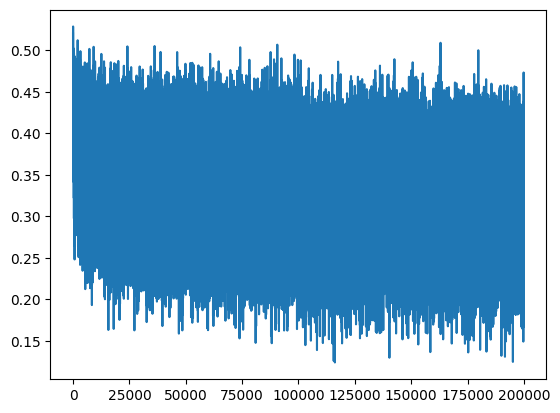

In [42]:
plt.plot(lossi);

In [43]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x]                          # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)
    
    # This part is new, just like we did with our new Batch Normalized NN
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    
    h = torch.tanh(hpreact)     # (N, n_hidden)
    logits = h @ W2 + b2        # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0668270587921143
val 2.104844808578491


In [44]:
# New: Calibrate the batch norm at the end of training
with torch.no_grad(): # this makes everything below faster, as "bookkeeping" is turned off
    # pass the (entire) training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set ONCE (cast them into stone)
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [45]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x]                          # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)
    
    # This part is new, just like we did with our new Batch Normalized NN
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias # Fix them, hold them, technologic
    
    h = torch.tanh(hpreact)             # (N, n_hidden)
    logits = h @ W2 + b2                # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

# Same losses as before
split_loss('train')
split_loss('val')

train 2.0668270587921143
val 2.1049270629882812


In [46]:
n_embd = 10
n_hidden = 200

# Initializations
g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # Small, but not 0
b2 = torch.randn(vocab_size,                      generator=g) * 0    # Biases are now all 0

bngain = torch.ones((1, n_hidden))  # 1 x 200, a 1 for each hidden neuron
bnbias = torch.zeros((1, n_hidden)) # 1 x 200, a bias for each hidden neuron

# These two don't require gradient derivation (not added to 'parameters')
bnmean_running = torch.zeros((1, n_hidden)) # hpreact starts as normal. distr. -> mean is 0
bnstd_running = torch.ones((1, n_hidden))   # hpreact starts as normal. distr. -> stddev is 1

parameters = [C, W1, b1, W2, b2, bngain, bnbias] # gain and bias are changed by backprop!!

for p in parameters:
    p.requires_grad = True

In [47]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y of this batch
    
    # Forward-Pass
    emb = C[Xb]                         
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 + b1
    
    # New: Mean and stddev definitions are outsourced to here
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad(): # This has nothing to do with gradient updating
        # Adding up small updates in the direction of current mean and stddev
        # This will build up to form a total mean and stddev right after training
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    
    h = torch.tanh(hpreact)             
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


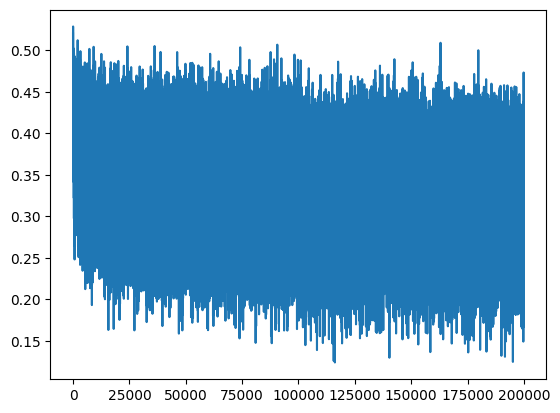

In [48]:
plt.plot(lossi);

In [49]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x]                          # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)
    
    # This part is new, just like we did with our new Batch Normalized NN
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    
    h = torch.tanh(hpreact)             # (N, n_hidden)
    logits = h @ W2 + b2                # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.06659197807312
val 2.1050572395324707


In [50]:
n_embd = 10
n_hidden = 200

# Initializations
g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01 # Turned off as not needed anymore (bnbias does the job)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # Small, but not 0
b2 = torch.randn(vocab_size,                      generator=g) * 0    # Biases are now all 0

bngain = torch.ones((1, n_hidden))  # 1 x 200, a 1 for each hidden neuron
bnbias = torch.zeros((1, n_hidden)) # 1 x 200, a bias for each hidden neuron

# These two don't require gradient derivation (not added to 'parameters')
bnmean_running = torch.zeros((1, n_hidden)) # hpreact starts as normal. distr. -> mean is 0
bnstd_running = torch.ones((1, n_hidden))   # hpreact starts as normal. distr. -> stddev is 1

parameters = [C, W1, W2, b2, bngain, bnbias] # gain and bias are changed by backprop!!

for p in parameters:
    p.requires_grad = True

In [51]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y of this batch
    
    # Forward-Pass
    emb = C[Xb]                         
    embcat = emb.view(emb.shape[0], -1) 
    
    # Linear Layer
    hpreact = embcat @ W1 #+ b1
    
    # Batch Normalization Layer
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad(): # This has nothing to do with gradient updating
        # Adding up small updates in the direction of current mean and stddev
        # This will build up to form a total mean and stddev right after training
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    # Non-Linearity
    h = torch.tanh(hpreact)             
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


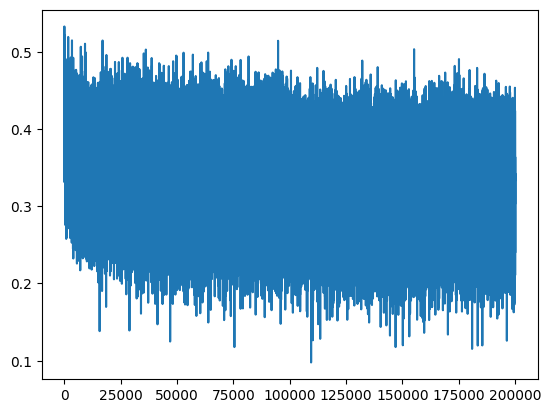

In [52]:
plt.plot(lossi);

In [53]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x]                          # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)
    
    # This part is new, just like we did with our new Batch Normalized NN
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    
    h = torch.tanh(hpreact)             # (N, n_hidden)
    logits = h @ W2 + b2                # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0674195289611816
val 2.105670690536499


In [54]:
m = torch.nn.Linear(10*3, 200) # Dimensions chosen to look just like our example
input = torch.randn(100, 30)   # 100 30-dimensional inputs, randomly generated
output = m(input)              # Feed inputs into the layer
print(output.size())           # we now should have 100 times 200 'neuron reactions'

torch.Size([100, 200])


In [55]:
# With 200 Learnable Parameters
m = torch.nn.BatchNorm1d(200) # Batch-Normalization receives 200 inputs, like in example above
# Without Learnable Parameters (not the usual thing to do tbh)
# m = nn.BatchNorm1d(200, affine=False)
input = torch.randn(20, 200)  # Let's throw in 20 inputs á 200 dimensions
output = m(input)
print(output)
print(output.shape) # 20 x 200, unchanged

tensor([[ 0.0684, -0.3200,  0.9205,  ...,  1.5225,  2.1172, -0.3888],
        [ 0.5073,  0.0306,  0.3444,  ...,  0.1666, -1.5774,  0.8612],
        [ 0.8290,  2.1434, -0.9400,  ...,  0.4714, -1.0725,  0.6069],
        ...,
        [-1.3373,  0.8072, -0.3307,  ...,  0.3548, -0.2353,  0.9387],
        [ 0.2624,  0.7444,  0.4764,  ..., -1.1067, -0.0792,  0.5146],
        [-1.2425, -0.2382,  1.0154,  ..., -0.8621, -0.1990, -0.5238]],
       grad_fn=<NativeBatchNormBackward0>)
torch.Size([20, 200])


In [56]:
# Linear Layer Definition (mimicing torch.nn.Linear's structure)
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    # Weights with Kaiming just like above would be (W1 * (5/3)/((n_embd * block_size)**0.5))
    # The term (5/3) is still missing, but that's because we don't have a non-linearity here yet
    # We'll add it later
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
    self.bias = torch.zeros(fan_out) if bias else None # Biases are optional here
  
  def __call__(self, x):
    self.out = x @ self.weight # W*x
    if self.bias is not None:  # Add biases if so desired
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias]) # return layer's tensors

In [58]:
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps            # Epsilon set to PyTorch default, you may change it
    self.momentum = momentum  # Momemtum set to PyTorch default, you may change it
    self.training = True
    # Initialize Parameters (trained with backprop)
    # (bngain -> gamma, bnbias -> beta)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # Initialize Buffers 
    # (Trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  

  def __call__(self, x):
    # Forward-Pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # Batch mean
      xvar = x.var(0, keepdim=True)   # Batch variance
    else:
      xmean = self.running_mean # Using the running mean as basis
      xvar = self.running_var   # Using the running variance as basis
    
    # Normalize to unit variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta  # Apply batch gain and bias
    
    # Update the running buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    
    return self.out
  

  def parameters(self):
    return [self.gamma, self.beta] # return layer's tensors

In [59]:
# Similar to torch.tanh(), but Class-structure to make later steps easier
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [60]:
n_embd = 10    # dimensionality of the character embedding vectors
n_hidden = 100 # number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
  Linear(n_embd * block_size, n_hidden),  Tanh(),
  Linear(n_hidden, n_hidden),  Tanh(),
  Linear(n_hidden, n_hidden),  Tanh(),
  Linear(n_hidden, n_hidden),  Tanh(),
  Linear(n_hidden, n_hidden),  Tanh(),
  Linear(n_hidden, vocab_size),
]

with torch.no_grad():
  # Last layer: make less confident
  layers[-1].weight *= 0.1
  # All other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

# Embedding matrix + all parameters in all layers = total involved parameters
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

# These parameters will be affected by backpropagation
for p in parameters:
  p.requires_grad = True

46497


In [61]:
# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # Minibatch-Construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch X,Y
  
    # Forward-Pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Stack up the layers in orginal order (one after another)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
  
    # Backward-Pass
    for layer in layers:
        # Stating that non-leaf variable gradients are to be kept/retained for evaluation
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # Update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Tracking stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
        
    break # Take this out to run full optimization/training

      0/ 200000: 3.2962


layer 1 (      Tanh): mean -0.02, std 0.75, saturated: 20.25%
layer 3 (      Tanh): mean -0.00, std 0.69, saturated: 8.38%
layer 5 (      Tanh): mean +0.00, std 0.67, saturated: 6.62%
layer 7 (      Tanh): mean -0.01, std 0.66, saturated: 5.47%
layer 9 (      Tanh): mean -0.02, std 0.66, saturated: 6.12%


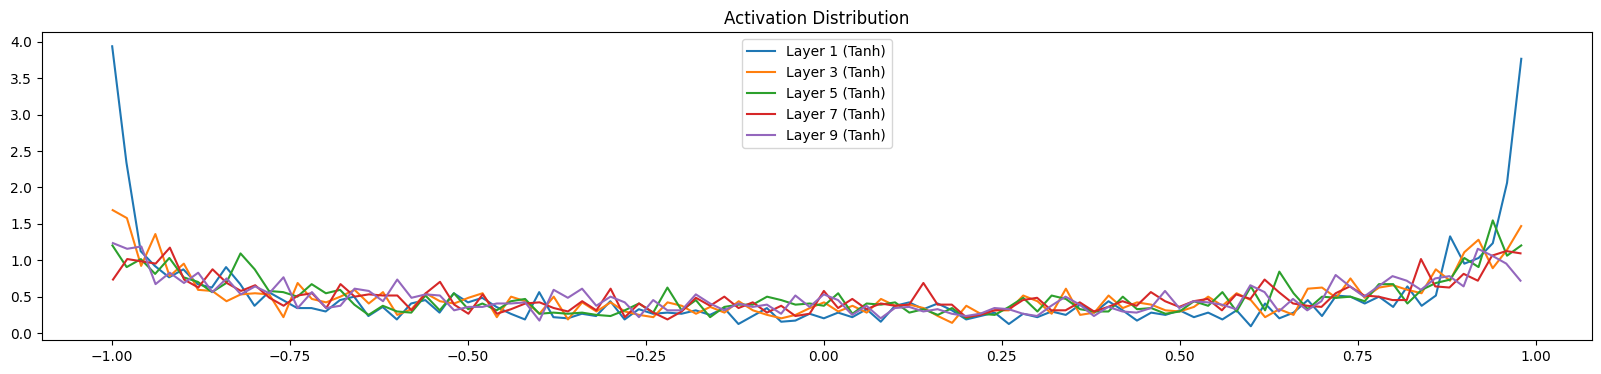

In [62]:
# Visualize histograms (forward pass activations) for the Tanh layers
# (below is what it looks like when Batch-Normalization is needed)
# We can see how many tensor values take on which x-axis values
plt.figure(figsize=(20, 4)) # Width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # Note: Excluding the output layer, these are all Tanh layers
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'Layer {i} ({layer.__class__.__name__})')
plt.title('Activation Distribution')
plt.legend(legends);

In [63]:
n_embd = 10    # dimensionality of the character embedding vectors
n_hidden = 100 # number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
]

with torch.no_grad():
  # Last layer: make less confident
  layers[-1].weight *= 0.1
  # All other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1 # Gain of 5/3 replaced by 1

# Embedding matrix + all parameters in all layers = total involved parameters
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

# These parameters will be affected by backpropagation
for p in parameters:
  p.requires_grad = True

46497


In [64]:
# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # Minibatch-Construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch X,Y
  
    # Forward-Pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Stack up the layers in orginal order (one after another)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
  
    # Backward-Pass
    for layer in layers:
        # Stating that non-leaf variable gradients are to be kept/retained for evaluation
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # Update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Tracking stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
        
    break # Take this out to run full optimization/training

      0/ 200000: 3.2988


layer 1 (      Tanh): mean -0.02, std 0.62, saturated: 3.50%
layer 3 (      Tanh): mean -0.00, std 0.48, saturated: 0.03%
layer 5 (      Tanh): mean +0.00, std 0.41, saturated: 0.06%
layer 7 (      Tanh): mean +0.00, std 0.35, saturated: 0.00%
layer 9 (      Tanh): mean -0.02, std 0.32, saturated: 0.00%


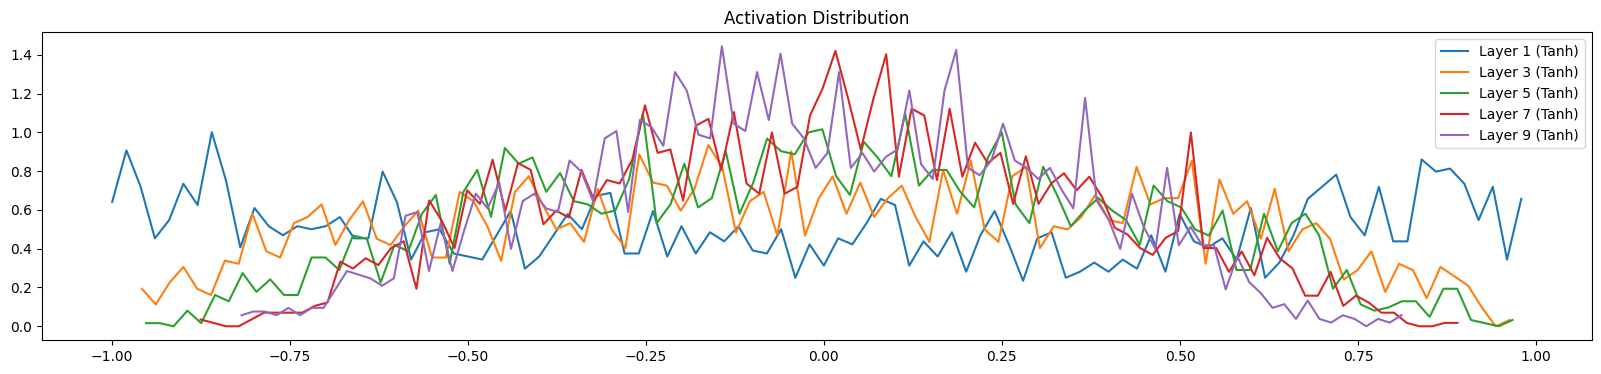

In [65]:
# Visualize activation histogram (i.e. activations) for the Tanh layers
# (below is what a worst-case looks like)
# We can see how many tensor values take on which x-axis values
plt.figure(figsize=(20, 4)) # Width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # Note: Excluding the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'Layer {i} ({layer.__class__.__name__})')
plt.title('Activation Distribution')
plt.legend(legends);

In [66]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
]

with torch.no_grad():
  # Last layer: make less confident
  layers[-1].weight *= 0.1
  # All other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

# Embedding matrix + all parameters in all layers = total involved parameters
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

# These parameters will be affected by backpropagation
for p in parameters:
  p.requires_grad = True

46497


In [67]:
# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # Minibatch-Construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch X,Y
  
    # Forward-Pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Stack up the layers in orginal order (one after another)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
  
    # Backward-Pass
    for layer in layers:
        # Stating that non-leaf variable gradients are to be kept/retained for evaluation
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # Update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Tracking stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
        
    break # Take this out to run full optimization/training

      0/ 200000: 3.2962


layer 1 (      Tanh): mean +0.000010, std 4.205588e-04
layer 3 (      Tanh): mean -0.000003, std 3.991179e-04
layer 5 (      Tanh): mean +0.000003, std 3.743020e-04
layer 7 (      Tanh): mean +0.000015, std 3.290473e-04
layer 9 (      Tanh): mean -0.000014, std 3.054035e-04


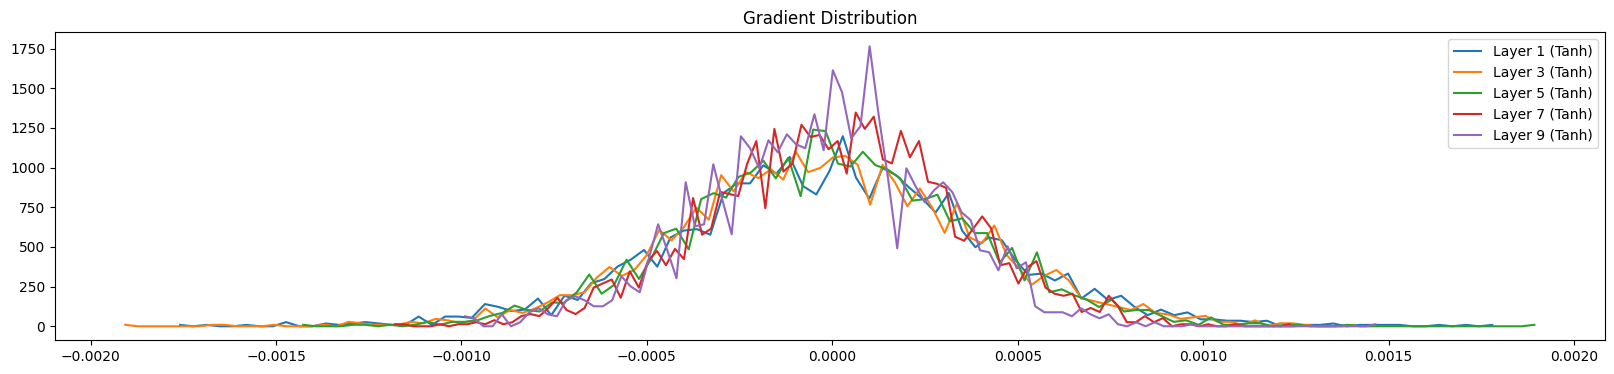

In [68]:
# Visualize Gradient Histogram (below is what it looks like ideally)
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'Layer {i} ({layer.__class__.__name__})')
plt.title('Gradient Distribution')
plt.legend(legends);

In [72]:
n_embd = 10    # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
  Linear(n_embd * block_size, n_hidden),  Tanh(),
  Linear(n_hidden, n_hidden),  Tanh(),
  Linear(n_hidden, n_hidden),  Tanh(),
  Linear(n_hidden, n_hidden),  Tanh(),
  Linear(n_hidden, n_hidden),  Tanh(),
  Linear(n_hidden, vocab_size),
]

with torch.no_grad():
  # Last layer: make less confident
  layers[-1].weight *= 0.1
  # All other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 0.5

# Embedding matrix + all parameters in all layers = total involved parameters
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

# These parameters will be affected by backpropagation
for p in parameters:
  p.requires_grad = True

46497


In [73]:
# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # Minibatch-Construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch X,Y
  
    # Forward-Pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Stack up the layers in orginal order (one after another)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
  
    # Backward-Pass
    for layer in layers:
        # Stating that non-leaf variable gradients are to be kept/retained for evaluation
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # Update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Tracking stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
        
    break # Take this out to run full optimization/training

      0/ 200000: 3.2960


layer 1 (      Tanh): mean +0.000000, std 1.892402e-05
layer 3 (      Tanh): mean -0.000001, std 3.943546e-05
layer 5 (      Tanh): mean +0.000004, std 8.035369e-05
layer 7 (      Tanh): mean +0.000009, std 1.561152e-04
layer 9 (      Tanh): mean -0.000014, std 3.053498e-04


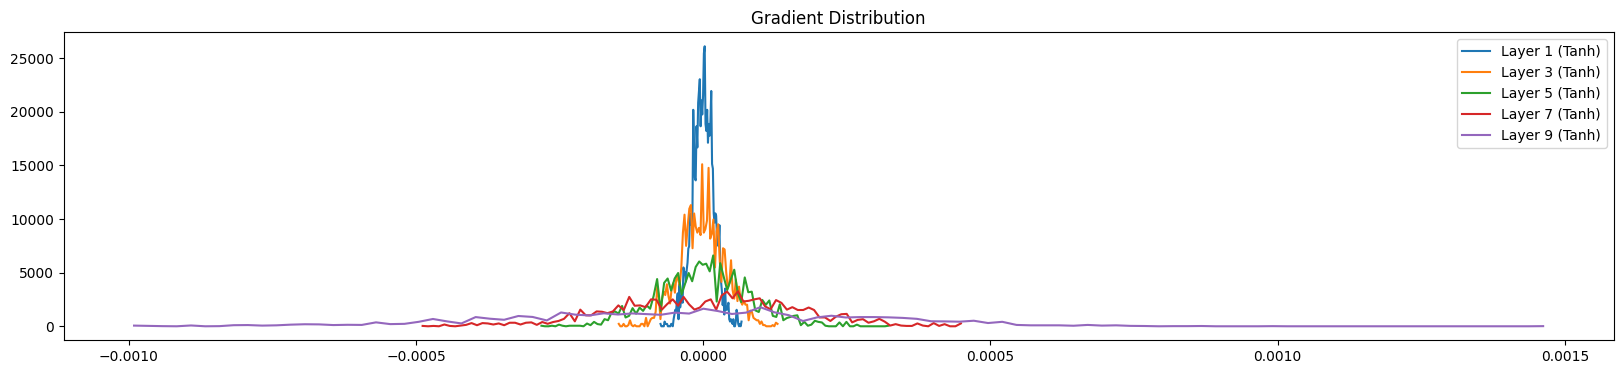

In [74]:
# Visualize Gradient Histogram
# (below is what you don't want it to look like)
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'Layer {i} ({layer.__class__.__name__})')
plt.title('Gradient Distribution')
plt.legend(legends);

In [75]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
  Linear(n_embd * block_size, n_hidden),
  Linear(n_hidden, n_hidden),
  Linear(n_hidden, n_hidden),
  Linear(n_hidden, n_hidden),
  Linear(n_hidden, n_hidden),
  Linear(n_hidden, vocab_size),
]

with torch.no_grad():
  # Last layer: make less confident
  layers[-1].weight *= 0.1
  # All other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 0.5

# Embedding matrix + all parameters in all layers = total involved parameters
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

# These parameters will be affected by backpropagation
for p in parameters:
  p.requires_grad = True

46497


In [76]:
# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # Minibatch-Construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch X,Y
  
    # Forward-Pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Stack up the layers in orginal order (one after another)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
  
    # Backward-Pass
    for layer in layers:
        # Stating that non-leaf variable gradients are to be kept/retained for evaluation
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # Update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Tracking stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
        
    break # Take this out to run full optimization/training

      0/ 200000: 3.2959


layer 0 (    Linear): mean -0.01, std 0.49, saturated: 5.06%
layer 1 (    Linear): mean -0.00, std 0.25, saturated: 0.00%
layer 2 (    Linear): mean -0.00, std 0.13, saturated: 0.00%
layer 3 (    Linear): mean +0.00, std 0.06, saturated: 0.00%
layer 4 (    Linear): mean -0.00, std 0.03, saturated: 0.00%


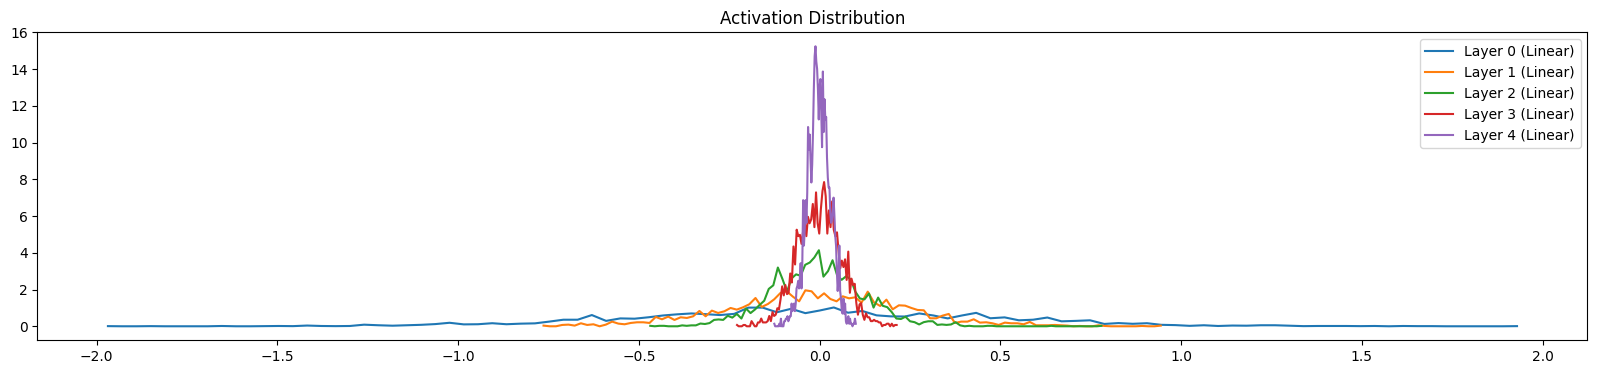

In [77]:
# Visualize activation histogram (i.e. activations) for the Linear layers
# (below is what it you don't want it to look like)
# High activation in deeper network parts only

# We can see how many tensor values take on which x-axis values
plt.figure(figsize=(20, 4)) # Width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # Note: Excluding the output layer
  if isinstance(layer, Linear):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'Layer {i} ({layer.__class__.__name__})')
plt.title('Activation Distribution')
plt.legend(legends);

layer 0 (    Linear): mean +0.000000, std 1.990759e-05
layer 1 (    Linear): mean -0.000001, std 3.997084e-05
layer 2 (    Linear): mean +0.000004, std 8.058026e-05
layer 3 (    Linear): mean +0.000009, std 1.562154e-04
layer 4 (    Linear): mean -0.000014, std 3.053490e-04


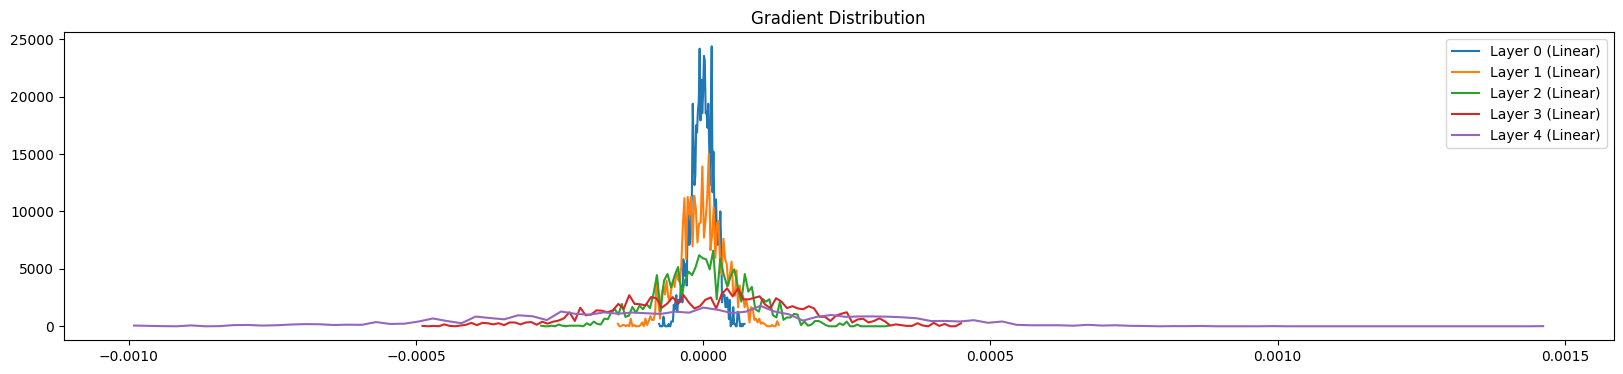

In [78]:
# Visualize Gradient Histogram
# (below is what you don't want it to look like)
# High Gradients (therefore large updates) only in shallow layers

plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Linear):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'Layer {i} ({layer.__class__.__name__})')
plt.title('Gradient Distribution')
plt.legend(legends);

In [79]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
  Linear(n_embd * block_size, n_hidden),  Tanh(),
  Linear(n_hidden, n_hidden),  Tanh(),
  Linear(n_hidden, n_hidden),  Tanh(),
  Linear(n_hidden, n_hidden),  Tanh(),
  Linear(n_hidden, n_hidden),  Tanh(),
  Linear(n_hidden, vocab_size),
]

with torch.no_grad():
  # Last layer: make less confident
  layers[-1].weight *= 0.1 # This makes the parameter ratio become an outlier (see graph)
  # All other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

# Embedding matrix + all parameters in all layers = total involved parameters
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

# These parameters will be affected by backpropagation
for p in parameters:
  p.requires_grad = True

46497


In [80]:
# Same optimization as last time
max_steps = 200000 
batch_size = 32    
lossi = []         # Keeping track of loss
ud = []            # Keeping track of Update-to-Data ratio

for i in range(max_steps):
  # Minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # Forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # Backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # Update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # Tracking the stats
  if i % 10000 == 0: # Print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2962


layer 1 (      Tanh): mean -0.04, std 0.76, saturated: 21.97%
layer 3 (      Tanh): mean -0.01, std 0.72, saturated: 11.00%
layer 5 (      Tanh): mean +0.01, std 0.73, saturated: 13.00%
layer 7 (      Tanh): mean -0.05, std 0.73, saturated: 13.34%
layer 9 (      Tanh): mean +0.00, std 0.72, saturated: 10.53%


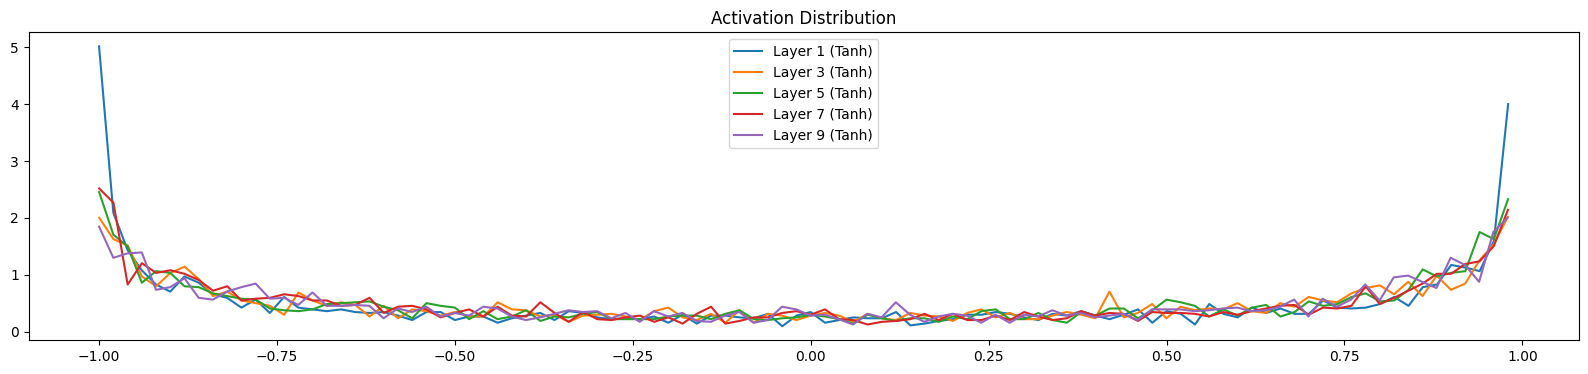

In [81]:
# Visualize histograms (forward pass activations) for the Tanh layers
# We can see how many tensor values take on which x-axis values
plt.figure(figsize=(20, 4)) # Width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # Note: Excluding the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'Layer {i} ({layer.__class__.__name__})')
plt.title('Activation Distribution')
plt.legend(legends);

layer 1 (      Tanh): mean +0.000024, std 3.353993e-03
layer 3 (      Tanh): mean +0.000012, std 3.157345e-03
layer 5 (      Tanh): mean -0.000004, std 2.925863e-03
layer 7 (      Tanh): mean +0.000036, std 2.715700e-03
layer 9 (      Tanh): mean +0.000020, std 2.308167e-03


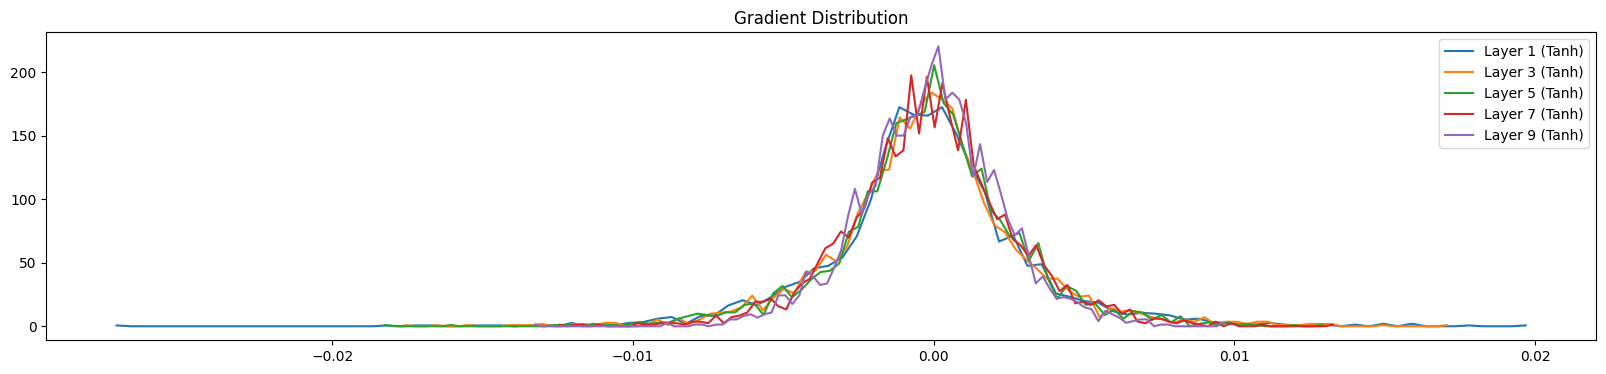

In [82]:
# Visualize Gradient Histogram (this graph looks good)
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'Layer {i} ({layer.__class__.__name__})')
plt.title('Gradient Distribution')
plt.legend(legends);

weight   (27, 10) | mean +0.000980 | std 1.189171e-02 | grad:data ratio 1.189149e-02
weight  (30, 100) | mean +0.000118 | std 1.005291e-02 | grad:data ratio 3.214557e-02
weight (100, 100) | mean +0.000033 | std 7.821215e-03 | grad:data ratio 4.653364e-02
weight (100, 100) | mean -0.000107 | std 6.655622e-03 | grad:data ratio 3.925852e-02
weight (100, 100) | mean -0.000017 | std 6.086041e-03 | grad:data ratio 3.605768e-02
weight (100, 100) | mean -0.000077 | std 5.075622e-03 | grad:data ratio 3.015270e-02
weight  (100, 27) | mean +0.000000 | std 2.056585e-02 | grad:data ratio 2.909911e-01


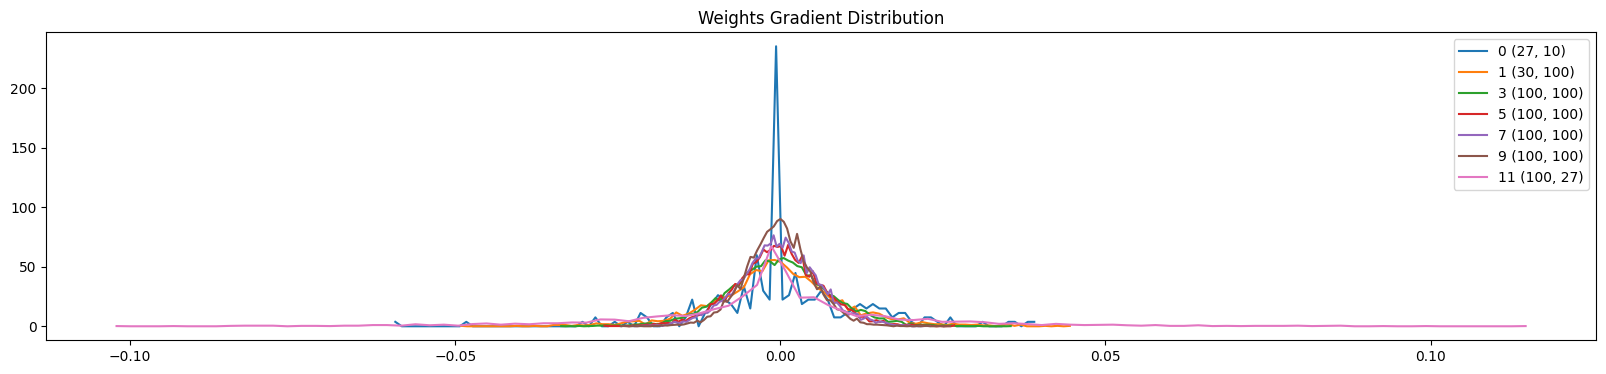

In [83]:
# Visualize histogram of weights of linear Layers (not biases, gammas or betas)
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('Weights Gradient Distribution');

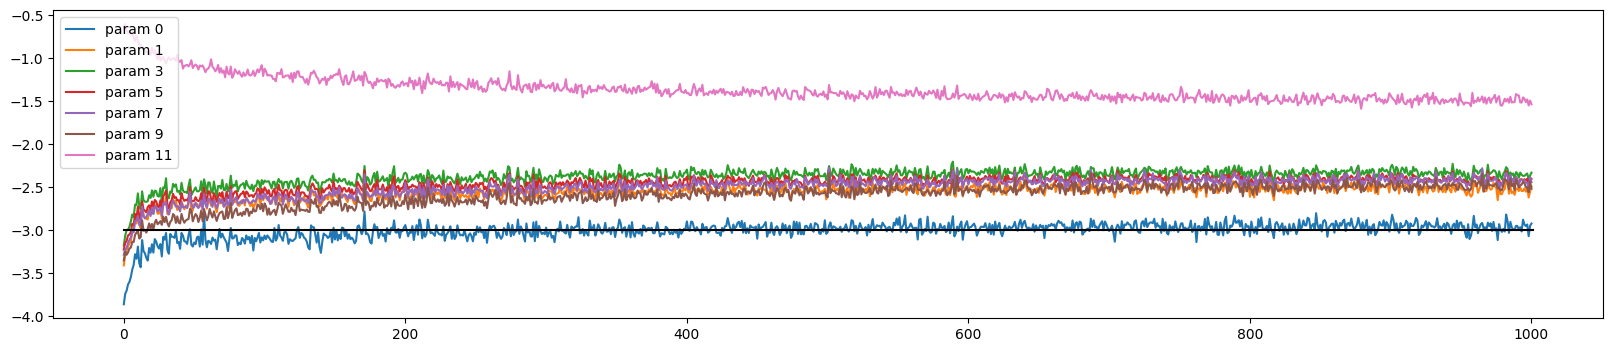

In [84]:
# Update to Data Ratio Histogram (below is what it looks like ideally)
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [85]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
  Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size), 
]

with torch.no_grad():
  # Last layer: make less confident
  layers[-1].gamma *= 0.1 # As last layer is a Batch-Normalization
  # All other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0

# Embedding matrix + all parameters in all layers = total involved parameters
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

# These parameters will be affected by backpropagation
for p in parameters:
  p.requires_grad = True

47551


In [86]:
# Same optimization as last time
max_steps = 200000 
batch_size = 32    
lossi = []         # Keeping track of loss
ud = []            # Keeping track of Update-to-Data ratio

for i in range(max_steps):
  # Minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # Forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # Backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # Update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # Tracking the stats
  if i % 10000 == 0: # Print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.56%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.25%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.69%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.88%


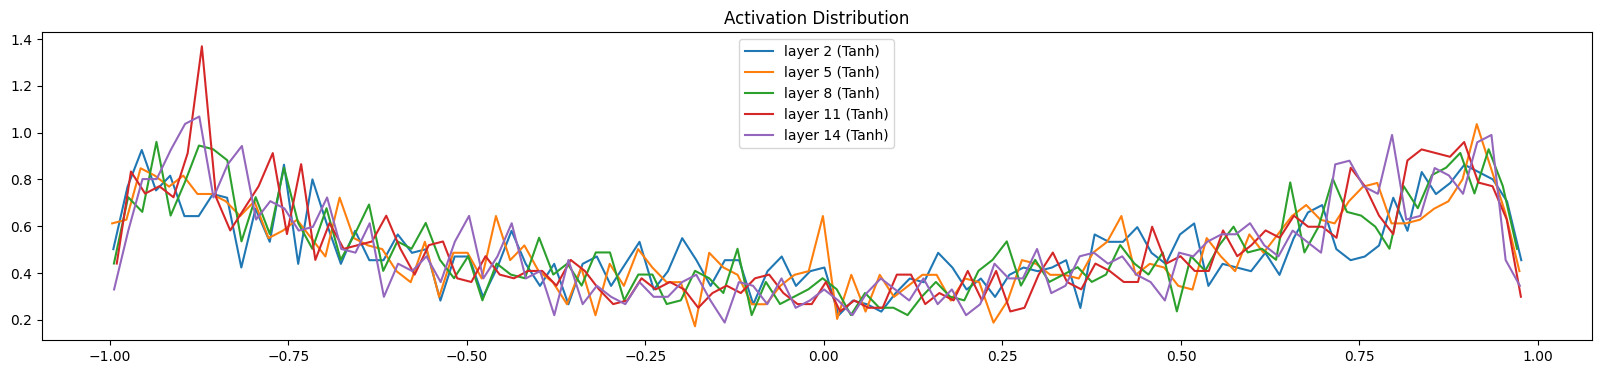

In [87]:
# Visualize histograms (forward pass activations) for the Tanh layers
# This is the ideal graph, very homogeneous
plt.figure(figsize=(20, 4)) # Width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # Note: Excluding the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.title('Activation Distribution')
plt.legend(legends);

layer 2 (      Tanh): mean -0.000000, std 2.640702e-03
layer 5 (      Tanh): mean -0.000000, std 2.245584e-03
layer 8 (      Tanh): mean +0.000000, std 2.045742e-03
layer 11 (      Tanh): mean +0.000000, std 1.983133e-03
layer 14 (      Tanh): mean -0.000000, std 1.952382e-03


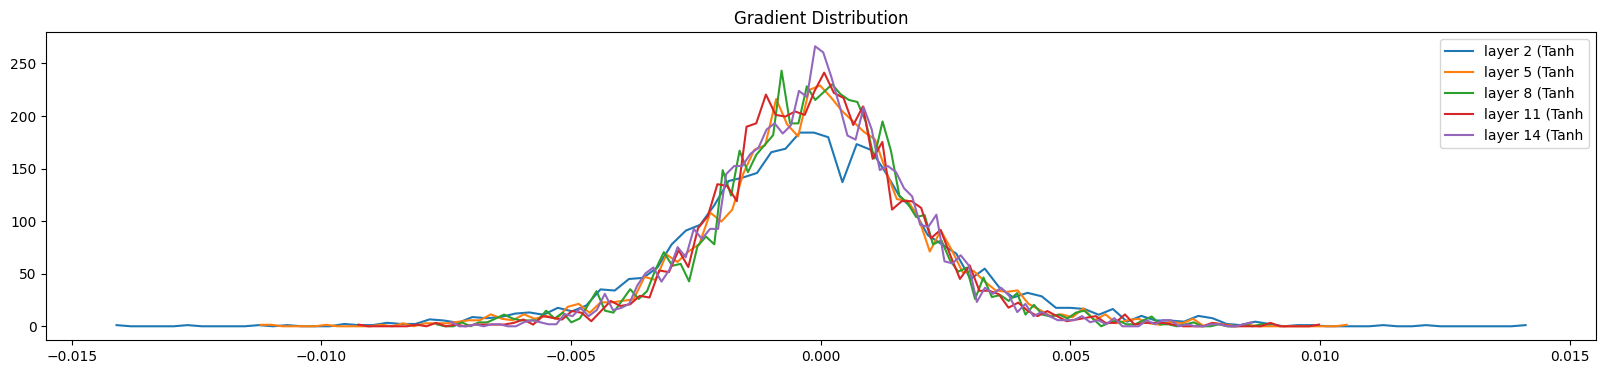

In [88]:
# Visualize Gradient Histogram (this graph looks good)
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.title('Gradient Distribution')
plt.legend(legends);

weight   (27, 10) | mean +0.000000 | std 8.020533e-03 | grad:data ratio 8.012629e-03
weight  (30, 100) | mean +0.000246 | std 9.241074e-03 | grad:data ratio 4.881090e-02
weight (100, 100) | mean +0.000113 | std 7.132879e-03 | grad:data ratio 6.964620e-02
weight (100, 100) | mean -0.000086 | std 6.234303e-03 | grad:data ratio 6.073739e-02
weight (100, 100) | mean +0.000052 | std 5.742183e-03 | grad:data ratio 5.631478e-02
weight (100, 100) | mean +0.000032 | std 5.672204e-03 | grad:data ratio 5.570124e-02
weight  (100, 27) | mean -0.000082 | std 1.209415e-02 | grad:data ratio 1.160105e-01


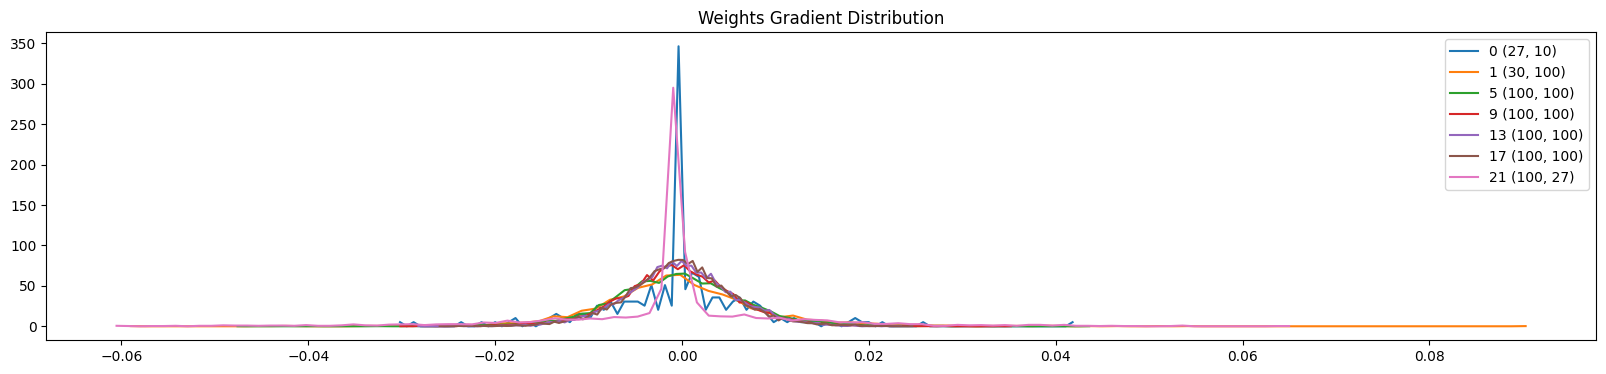

In [89]:
# Visualize histogram of weights of linear Layers (not biases, gammas or betas)
# Ideal graph
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('Weights Gradient Distribution');

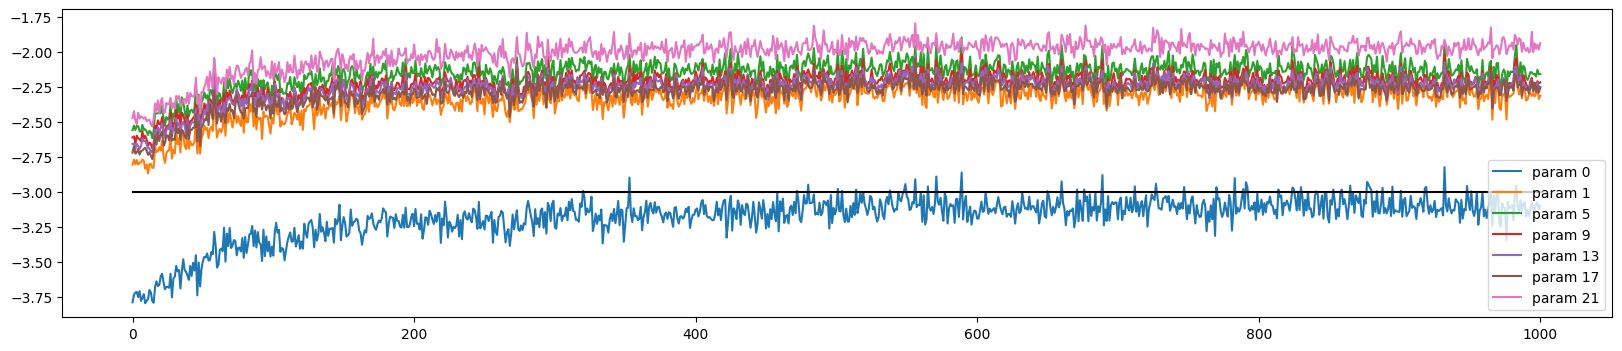

In [90]:
# Update to Data Ratio Histogram (below is what it looks like ideally)
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);